<a href="https://colab.research.google.com/github/andxeg/MPI_Program_Execution_Time_Prediction/blob/master/final_compare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MPI programs execution time prediction using Ridge, Cliques, ALS and ensemble algrithm

This notebook introduces MPI programs execution time prediction algorithm base on the following algorithms:
- Ridge regression
- Grouping computer installation based on Pearson correlation coefficient
- ALS matrix decomposition
- Ensemble of the algorithm above. Averaging ensemble is used.

Algorithms above predicts MPI program execution time on the certain set of computer installation. Computer installation is high-performance computing cluster, data center or supercomputer.

We use data from spec.org:
- MPI benchmarks [https://spec.org/mpi2007/results/mpi2007.html];
- OpenMP benchmarks [https://spec.org/accel/results/accel.html].

Data is constantly updated, so we add it to our repository too.

## Prerequisites
- Download dataset
- Create some directories
- Install necessary packages

In [ ]:
! git clone https://github.com/andxeg/MoNeTec_2020_Embeddings.git

Cloning into 'MoNeTec_2020_Embeddings'...
remote: Enumerating objects: 1740, done.
remote: Counting objects: 100% (1740/1740), done.
remote: Compressing objects: 100% (298/298), done.
remote: Total 1740 (delta 1439), reused 1740 (delta 1439), pack-reused 0
Receiving objects: 100% (1740/1740), 2.66 MiB | 3.38 MiB/s, done.
Resolving deltas: 100% (1439/1439), done.


In [ ]:
!ls -la

total 20
drwxr-xr-x 1 root root 4096 Nov  7 23:22 .
drwxr-xr-x 1 root root 4096 Nov  7 23:18 ..
drwxr-xr-x 4 root root 4096 Nov  1 13:34 .config
drwxr-xr-x 5 root root 4096 Nov  7 23:22 MoNeTec_2020_Embeddings
drwxr-xr-x 1 root root 4096 Nov  1 13:35 sample_data


In [ ]:
%cd ./MoNeTec_2020_Embeddings/data/benchmarks

/content/MoNeTec_2020_Embeddings/data/benchmarks


In [ ]:
!ls -la 

total 92
drwxr-xr-x 6 root root  4096 Nov  7 23:22 .
drwxr-xr-x 3 root root  4096 Nov  7 23:22 ..
drwxr-xr-x 2 root root 20480 Nov  7 23:22 meta_mpi
drwxr-xr-x 2 root root 36864 Nov  7 23:22 mpi_logs
drwxr-xr-x 2 root root  4096 Nov  7 23:22 preprocessed
drwxr-xr-x 2 root root 20480 Nov  7 23:22 preprocessed_mpi


In [ ]:
!mkdir ./preprocessed_mpi/
!mkdir ./meta_mpi/

mkdir: cannot create directory ‘./preprocessed_mpi/’: File exists
mkdir: cannot create directory ‘./meta_mpi/’: File exists


In [ ]:
!rm ./preprocessed_mpi/*
!pwd

/content/MoNeTec_2020_Embeddings/data/benchmarks


In [ ]:
!python --version

Python 3.7.12


In [ ]:
!pip install pandas numpy matplotlib scikit-learn scipy tqdm

## Parse csv with results of programs execution

In [ ]:
import pandas as pd
import numpy as np
import glob
import random
from tqdm import tqdm

In [ ]:
# Read data with MPI benchmarks executions on the different computer installation
for j, i in enumerate(glob.glob('./mpi_logs/*.csv')):
    print(i)
    accel = open(i,'r').readlines()
    f=open('./preprocessed_mpi/'+str(j) + ".csv", 'w')
    f.write("".join(accel[accel.index('"Selected Results Table"\n')+2:accel.index('"Selected Results Table"\n')+16]))
    f.close()
    f=open('./meta_mpi/'+str(j)+".csv", 'w')
    try:
        #f.write("".join(accel[accel.index('HARDWARE\n'):accel.index('"General Notes"\n')]))
        f.write("".join(accel[accel.index('HARDWARE\n'):accel.index('"Node Description: NFS"\n')]))
    except:
        f.write("".join(accel[accel.index('HARDWARE\n'):]))
    f.close()

logs =[]
for i in glob.glob('./preprocessed_mpi/*'):
    logs.append(pd.read_csv(i))

./mpi_logs/mpi2007-20150526-00493.csv
./mpi_logs/mpi2007-20080702-00052.csv
./mpi_logs/mpi2007-20120221-00353.csv
./mpi_logs/mpi2007-20081225-00088.csv
./mpi_logs/mpi2007-20090428-00139.csv
./mpi_logs/mpi2007-20110304-00257.csv
./mpi_logs/mpi2007-20120221-00351.csv
./mpi_logs/mpi2007-20080702-00053.csv
./mpi_logs/mpi2007-20081203-00084.csv
./mpi_logs/mpi2007-20120207-00346.csv
./mpi_logs/mpi2007-20140106-00425.csv
./mpi_logs/mpi2007-20070614-00025.csv
./mpi_logs/mpi2007-20130820-00398.csv
./mpi_logs/mpi2007-20090302-00095.csv
./mpi_logs/mpi2007-20190312-00616.csv
./mpi_logs/mpi2007-20090922-00177.csv
./mpi_logs/mpi2007-20071013-00030.csv
./mpi_logs/mpi2007-20100921-00246.csv
./mpi_logs/mpi2007-20140218-00444.csv
./mpi_logs/mpi2007-20140902-00473.csv
./mpi_logs/mpi2007-20070525-00001.csv
./mpi_logs/mpi2007-20100223-00207.csv
./mpi_logs/mpi2007-20160727-00518.csv
./mpi_logs/mpi2007-20120221-00370.csv
./mpi_logs/mpi2007-20090728-00172.csv
./mpi_logs/mpi2007-20171011-00585.csv
./mpi_logs/m

In [ ]:
# Prepare data for PC matrix creation

computers={}
for j,i in enumerate(logs):
    if i['Base Run Time'].iloc[0] =='NC':
        continue
    computers[j]={'Run Time': i['Base Run Time']}
    if i['Benchmark'].iloc[0] == '121.pop2':
        computers[j]['class'] = 1
    else:
        computers[j]['class'] = 2

class_1 = {}
class_2 = {}
for item in computers.items():
    if item[1]['class'] == 1:
        class_1[item[0]]=item[1]['Run Time']
    else:
        if np.isnan(item[1]['Run Time']).any():
            continue
        class_2[item[0]]=item[1]['Run Time']

In [ ]:
# Prepare data for PC matrix creation
logs =[]
for i in glob.glob('./preprocessed/*'):
    logs.append(pd.read_csv(i))

computers={}
for j,i in enumerate(logs):
    computers[j]=i['Base Ratio']
df = pd.DataFrame.from_records(computers)    

## Choose appropriate data set
- MPIL2007 -- 12 programs, 163 computer installations
- MPIM2007 -- 13 programs, 396 computer installations
- ACCEL_OMP -- 15 programs, 25 computer installations

## Create PC matrix

In [ ]:
# df= pd.DataFrame.from_records(class_1) # Mpi 12x163
df= pd.DataFrame.from_records(class_2) # Mpi 13*396
# df= pd.DataFrame.from_records(computers)  # Accel opemmp

In [ ]:
df

,1,2,3,4,5,6,8,9,10,11,15,16,17,18,19,21,22,24,26,27,28,29,30,31,32,34,35,36,37,38,39,41,42,43,45,46,48,49,50,51,...,526,528,529,530,531,532,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,550,552,555,557,558,559,560,564,566,567,568,570,573,574,575,577,578,579,580
0,15.364740,207.7,700.660535,33.320302,65.874527,47.433990,94.815893,6.988289,317.401075,473.320781,183.261600,55.090541,47.776947,291.696447,33.820130,125.554151,42.039596,19.857905,86.004027,56.281590,31.705661,20.551419,32.288509,270.323651,179.863763,142.577624,83.041239,355.838718,163.840630,153.539363,426.213185,97.545377,162.953176,127.378413,105.805730,53.775434,100.901167,62.517829,43.354320,112.157310,...,386.324542,107.867020,24.249903,49.369338,50.597294,61.067794,103.670506,586.123365,359.884975,211.396205,12.167641,54.563188,200.244916,648.762047,189.421439,191.292796,15.870054,316.205252,67.804184,389.129703,453.238996,439.303455,72.486488,433.852518,24.293740,23.738117,55.281823,406.537755,34.554959,222.336642,54.072404,126.370101,101.957246,47.464406,90.617188,126.921722,1549.904813,508.037446,152.659348,151.970232
1,41.757358,740.7,2519.218538,126.375770,160.306838,140.629037,272.437986,21.086055,842.326298,1655.736209,483.128371,138.776409,131.610235,659.615110,73.988350,439.522958,105.900880,61.248167,219.097651,194.787491,125.970215,78.573564,126.780797,652.708534,477.922814,454.811507,351.141263,1202.395421,533.190913,369.222218,1498.182114,322.982538,516.585431,318.096433,384.592714,191.010457,340.735778,223.152957,106.330852,408.392469,...,990.164237,437.686694,58.704114,119.634791,144.284826,193.185014,381.166608,1668.094235,1411.493003,769.580034,38.952680,125.274629,520.420449,1810.903544,666.074425,508.786054,53.844638,893.138208,273.060829,1224.882981,1030.675054,1042.733189,180.051571,1522.947676,66.825617,56.900651,145.382601,1049.322888,91.333531,765.431638,202.218945,371.258963,271.151819,119.751074,248.820814,365.427017,5230.784191,1328.476288,507.466854,394.906397
2,249.716353,507.6,2063.012665,271.456838,148.874870,324.932551,217.104949,169.497890,775.281699,1416.842258,374.541888,321.825367,212.732709,594.704711,316.467433,339.848322,165.226648,273.809992,227.507224,244.526049,197.341883,346.043410,281.589520,557.858636,365.423551,335.619525,886.384872,956.255742,407.715104,304.379609,1159.142589,237.616333,377.795449,297.865062,276.803203,242.124124,246.975479,195.228010,279.990239,290.122638,...,738.476124,294.355766,187.532850,147.481406,478.129575,165.650769,270.100894,1091.926974,938.908886,562.043451,324.954430,141.489873,395.852049,1677.586840,466.335012,389.597138,358.527337,712.515293,639.902562,868.984454,815.527933,1580.437325,157.083978,1238.947989,308.463069,201.127791,532.294270,836.724717,149.772383,532.704041,188.689887,295.028181,389.878879,140.285307,203.532208,279.033136,6568.863362,1077.158206,371.638385,355.062588
3,19.469998,300.9,881.593303,33.026178,80.046037,63.036408,107.798620,13.770920,277.150143,656.979511,197.314045,66.322830,39.504504,221.496130,59.009974,190.080994,36.363687,19.864782,104.339302,63.040485,24.305793,17.198605,31.509672,299.822874,183.400123,162.636802,86.328366,370.753902,192.456676,167.763592,570.159751,141.425349,202.842596,170.794644,159.649388,59.961335,145.397277,102.285772,26.050389,175.675864,...,451.743756,167.306224,29.246298,56.916712,51.164390,69.647977,160.809606,710.334040,642.039853,315.247693,12.253796,45.606429,218.962454,1059.750783,232.104074,197.998879,15.101063,375.553646,34.125497,463.667555,446.357647,398.976396,74.879310,586.824982,20.526460,54.413640,81.141503,439.603684,28.606430,311.443932,88.660586,157.731487,79.523853,48.972629,101.320277,141.784394,1994.095434,549.992459,218.877966,212.187807
4,181.022050,509.5,1295.957962,190.094130,219.379912,173.760583,330.904450,65.038169,486.891881,988.953733,326.031305,171.005751,179.983597,544.402442,121.254296,354.030349,111.666979,180.191049,135.283146,222.914279,259.375144,155.609302,238.558964,503.7

## Matrix factorization

In [ ]:
import matplotlib.pyplot as plt 
plt.rcParams['figure.figsize'] = [20, 10]
def runALS(A, R, n_factors, n_iterations, lambda_):
    n, m = A.shape
    W = 3 * np.random.rand(n, n_factors)
    H = 3 * np.random.rand(n_factors, m)
    A_copy = A
    A = A*R
    def get_error(A, W, H, R):
        return np.sum((np.invert(R) * np.abs(A_copy - np.dot(W, H))) / A_copy) /np.sum(np.invert(R))

    MSE_List = []
    for iter in range(n_iterations):
        for i, Ri in enumerate(R):
            W[i] = np.linalg.solve(np.dot(H, np.dot(np.diag(Ri), H.T)) + lambda_ * np.eye(n_factors),
                                       np.dot(H, np.dot(np.diag(Ri), A[i].T))).T
        #print("Error after solving for W Matrix:", get_error(A, W, H, R))

        for j, Rj in enumerate(R.T):
            H[:,j] = np.linalg.solve(np.dot(W.T, np.dot(np.diag(Rj), W)) + lambda_ * np.eye(n_factors),
                                     np.dot(W.T, np.dot(np.diag(Rj), A[:, j])))
        #print("Error after solving for H Matrix:", get_error(A, W, H, R))

        MSE_List.append(get_error(A, W, H, R))
        
    return W, H, MSE_List[-1]



## Some useful functions¶

In [ ]:
def nul_2(df_2, cells, i=-1, j = -1):
    
    if i<0:
        i = random.choice(range(df_2.shape[0]))
    if j<0:
        j = random.choice(range(df_2.shape[1]))
    
    df_2[i, j] = 0
    return df_2, i, j 
def gen_X(df_2, cell):
    train = []
    df_np = df_2
    for i in range(df.shape[0]):
        if i != cell[0]:
            train.append(np.concatenate([df_np[i][:cell[1]], df_np[i][cell[1]+1:]]))
    return np.array(train)
    
def gen_Y(df_2, cell): 
    df_np = df_2
    return np.concatenate([df_np[:cell[0],cell[1]], df_np[cell[0]+1:,cell[1]]])
    
    
def gen_predict(df_2, cell):
    df_np = df_2
    return [np.concatenate([df_np[cell[0]][:cell[1]], df_np[cell[0]][cell[1]+1:]])]

## Ridge regression

In [ ]:
from sklearn.linear_model import Ridge

In [ ]:
def predict_Ridge(cells, df_np):
    diff = []
    res=[]
    for cell in cells:
        z = Ridge()
        z.fit(gen_X(df_np, cell), gen_Y(df_np, cell))
        y = z.predict(gen_predict(df_np, cell))
        res.append(y)
        #Создать результирующую матрицу
        diff.append(np.abs(y - A[cell[0],cell[1]]) / A[cell[0],cell[1]])
    #return np.mean(diff)
    return res

## Define error function to compare algorithms

In [ ]:
def get_error(pred, true):
    return np.mean(np.abs(pred - true) / true)

## Define function to make outliers in source data sets

In [ ]:
def mul_2(df_2, const=4, i=-1, j = -1):
    
    if i<0:
        i = random.choice(range(df_2.shape[0]))
    if j<0:
        j = random.choice(range(df_2.shape[1]))
    
    df_2[i, j] *=(0.01+random.random()) * const
    return df_2, i, j 

## Prediction algorithm based on grouping computer installation based on Pearson correlation coefficient

In [ ]:
import networkx as nx
from networkx.algorithms.clique import find_cliques
from networkx.algorithms.approximation.clique import clique_removal
from networkx.algorithms.clique import enumerate_all_cliques

In [ ]:
np.seterr(all='raise')
def predict_Clicks(cells, df_numpy):
#     print(df_numpy)
    CORR_THRESHOLD = 0.75
    index_rows = range(df.shape[0])# Which tasks to use to predict correlation
    task_id = 2
    df_numpy = np.array([df_numpy[i] for i in index_rows])

    import scipy.stats
    z=[]
    graph = {}
    for i in range(df.shape[1]):
        gr_ = {}
        for j in range(df.shape[1]):
            gr_[j] = scipy.stats.pearsonr(df_numpy[:,i], df_numpy[:,j])[0]
        graph[i]=gr_
    #return pd.DataFrame.from_records(graph)
    
    '''
    print("Networkx:")
    bins = []
    for i in find_cliques(G):
      bins.append(i)
    return bins
    #for k in find_cliques(G):
    #  print(k)
    '''

    def check_is_good(i, gr):
        for j in gr:
            if graph[i][j] < CORR_THRESHOLD:
                return False
        else:
            return True

    ''' Cliques '''
    bins=[set()]
    alone_nodes = [i for i in range(df.shape[1])]
    random.shuffle(z)
    for i in range(df.shape[1]):
        flag = 1
        for bin_ in bins:
            if check_is_good(i, bin_):
                bin_.add(i)
                flag=0
        if flag:
            bins.append({i})

    alone =[]
    for bin_ in bins:
        if len(bin_) <2:
            alone.append(bin_)
    for i in alone:
        bins.remove(i)
    #return bins


    def predict_by_bin(bin_, cell):
        #df_numpy = df.to_numpy()
        df_np = np.array([df_numpy[i] for i in index_rows])
        coefs = []
        predicts = []
        without_j = np.concatenate([df_np[:cell[0]], df_np[cell[0]+1:]])
        for i in bin_:
            if i!=cell[1]:
                try:
                    coef = np.mean( without_j[:, cell[1]] / without_j[:,i])
                except:
                    continue
                coefs.append(coef)
                predicts.append(df_numpy[cell[0], i] * coef)
        try:
            return np.abs(np.mean(predicts))
        except:
            return 0
        


    preds = {}
    c = 0
    res = []
    result = df_numpy.copy()
    #print(result.shape)
    for task_id in range(12):
        for c in range(len(bins)):
            for j in bins[c]:
                pred = []
                pred.append(predict_by_bin(bins[c], [task_id, j]))
                preds[j] = pred
                result[task_id,j] = np.mean(pred)
            #for j in bins[c]:
            #    res.append([ np.mean(preds[j]), np.max(preds[j]), j])
                
        
    return result

    # Create final matrix
    n=[]
    for i in res:
        n.append(i[0])
    return n    
    score = (np.mean(n) * (df_numpy.shape[1] - len(alone)) + predict_Ridge(cells, df_numpy) * (len(alone))) / df_numpy.shape[1]
    print(len(alone))
    return score

## Make prediction using Ridge Regression, ALS decomposition with K=1, grouping based on Pearson correlation coefficient and ensemble

In [ ]:
A = df.to_numpy()
l_ = []
l__ =[]
points = [1, 5, 10, 15, 20, 27, 35, 45, 55, 65, 75, 85, 100, 118, 135, 150, 175, 200, 250, 300]
# points = range(1, 30, 2)


# Uncomment code below if you want add outliers to sources data sets
# for i in range(int(A.shape[0]*A.shape[1]/9)):
# # #     A,k,l = mul_2(A, 4)
#     A,k,l = mul_2(A, 10)

    
for point in tqdm(points):
    losses=[]
    ridge_losses =[]
    clicks_losses = []
    R = np.invert(np.zeros(A.shape, dtype=np.bool))    
    cells = []
    point = int(A.shape[0]*A.shape[1]*point/100)
    
    for i in range(point):
        R,k,l = nul_2(R, cells)
        cells.append((k,l))
    df_np = A*R
    ridge_losses = predict_Ridge(cells, df_np)
    W_, H_, loss = runALS(A, R, n_factors = 1, n_iterations = 2, lambda_ = .3)
    
    clicks_losses = (predict_Clicks(cells, df_np))
    ridge_m = df_np.copy()
    decompose = df_np.copy()
    pr = W_ *H_
    for k, cell in enumerate(cells):
        ridge_m[cell[0], cell[1]] =  ridge_losses[k]
        decompose[cell[0], cell[1]] = pr[cell[0], cell[1]]
    
    clicks_l = ridge_m.copy()
    for k, cell in enumerate(cells):
        i=cell[0]
        j=cell[1]
        decompose[i,j] = (W_*H_)[i,j]
        if clicks_losses[i,j]>0:
            clicks_l[i,j] = clicks_losses[i,j]
    ensemble = np.average([decompose, ridge_m, clicks_l], axis=0, weights=[0.6,0.2,0.2])
    '''
    print((W_*H_).shape)
    print(A.shape)
    print(ridge_m)
    '''
    l_.append([np.sum(100*np.invert(R))/(A.shape[0]*A.shape[1]), get_error(decompose, A), get_error(ridge_m, A), get_error(ensemble,A), get_error(clicks_l, A)])


  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
  5%|▌         | 1/20 [00:16<05:15, 16.59s/it]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
 10%|█         | 2/20 [00:30<04:35, 15.30s/it]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
 15%|█▌        | 3/20 [00:43<03:57, 13.97s/it]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
 20%|██        | 4/20 [00:54<03:28, 13.01s/it]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
 25%|██▌       | 5/20 [01:06<03:05, 12.38s/it]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: 

## Prepare to graph

In [ ]:
ALS_losses = []
percents = []
ridge_losses = []
ensemble_losses = []
clicks_losses = []
for i,k in enumerate(points):
    ALS_losses.append(l_[i][1])
    percents.append(l_[i][0])
    ridge_losses.append(l_[i][2])
    ensemble_losses.append(l_[i][3])
    clicks_losses.append(l_[i][4])

max_index = -1
percents = percents[:max_index]
ALS_losses =   ALS_losses [:max_index]
ridge_losses = ridge_losses [:max_index]
ensemble_losses=ensemble_losses[:max_index]
clicks_losses =clicks_losses [:max_index]

print(np.array(ALS_losses).shape)
print(np.array(ridge_losses).shape)
print(np.array(clicks_losses))

(19,)
(19,)
[0.00239258 0.01165517 0.02718752 0.05340203 0.07336965 0.10364869
 0.1375346  0.18092801 0.22835395 0.27030524 0.33184216 0.35698917
 0.43334979 0.52240991 0.55373393 0.59742165 0.68040104 0.76072379
 0.85406436]


In [ ]:
import math

for i,p in enumerate(percents):
    print("%5d%% | Ridge: %10f | Pearson: %10f | ALS: %10f | Ensemble: %10f" % (math.ceil(p), ridge_losses[i], clicks_losses[i], ALS_losses[i], ensemble_losses[i]))

    1% | Ridge:   0.002718 | Pearson:   0.002393 | ALS:   0.004183 | Ensemble:   0.003258
    5% | Ridge:   0.014466 | Pearson:   0.011655 | ALS:   0.018571 | Ensemble:   0.014741
   10% | Ridge:   0.032949 | Pearson:   0.027188 | ALS:   0.036867 | Ensemble:   0.029850
   15% | Ridge:   0.060607 | Pearson:   0.053402 | ALS:   0.061019 | Ensemble:   0.051545
   19% | Ridge:   0.076316 | Pearson:   0.073370 | ALS:   0.074161 | Ensemble:   0.063029
   24% | Ridge:   0.104970 | Pearson:   0.103649 | ALS:   0.094095 | Ensemble:   0.081591
   30% | Ridge:   0.148003 | Pearson:   0.137535 | ALS:   0.118358 | Ensemble:   0.108205
   36% | Ridge:   0.181279 | Pearson:   0.180928 | ALS:   0.133837 | Ensemble:   0.127186
   42% | Ridge:   0.228354 | Pearson:   0.228354 | ALS:   0.170425 | Ensemble:   0.156296
   49% | Ridge:   0.270305 | Pearson:   0.270305 | ALS:   0.203243 | Ensemble:   0.181913
   53% | Ridge:   0.331842 | Pearson:   0.331842 | ALS:   0.224458 | Ensemble:   0.213372
   58% | R

## Graphics

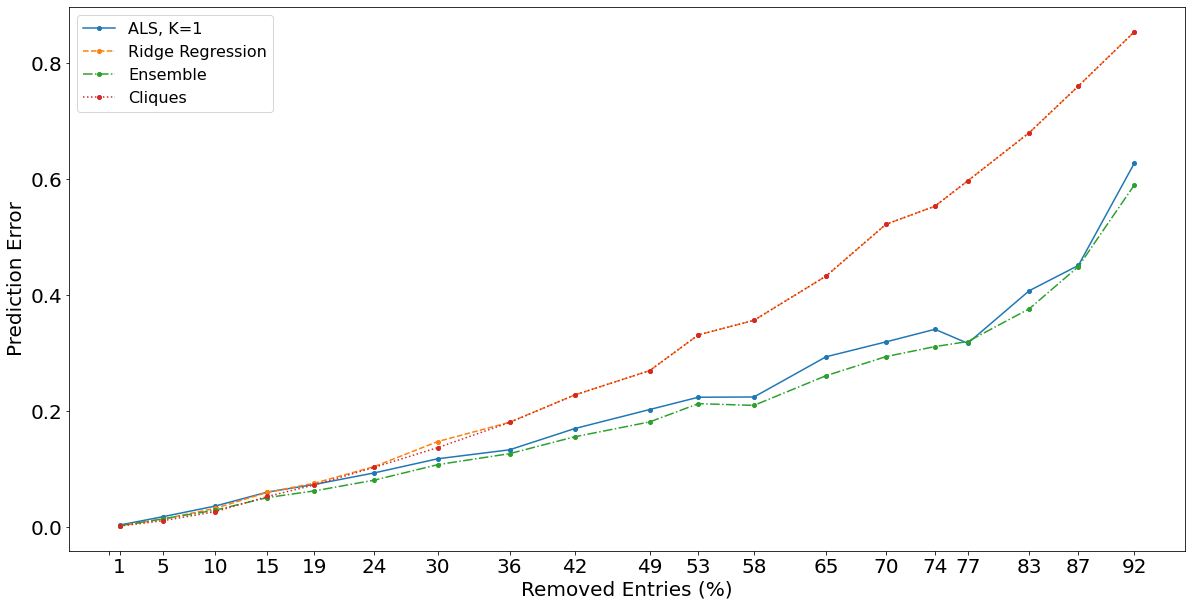

In [ ]:
import math

# fig = plt.figure(num=None, figsize=(20, 5), dpi=80, facecolor='w', edgecolor='k')
fig = plt.figure()
ax = fig.add_subplot(111)

# plt.plot(range(0, len(ridge_losses) + 1), [1 for i in range(0, len(ridge_losses) + 1)], color="red")

plt.plot(percents, ALS_losses, linestyle='-', marker='o', markersize=4, label='ALS, K=1')
plt.plot(percents, ridge_losses, linestyle='--', marker='o', markersize=4, label='Ridge Regression')
plt.plot(percents, ensemble_losses, linestyle='-.', marker='o', markersize=4, label='Ensemble')
plt.plot(percents, clicks_losses, linestyle=':', marker='o', markersize=4, label='Cliques')


# Custom ticks, miss some values
xticks = [math.ceil(p) for p in percents]
# xticks = [int(p * 100) / 100.0 for p in percents]
xticks.insert(0, None)
# xticks[11] = None
# xticks[15] = None
# plt.xticks(range(0,len(points)+1), xticks, rotation=90, fontsize=14)
# 
plt.xticks([0] + percents, xticks, rotation=0, fontsize=20)
plt.yticks(fontsize=20)

plt.legend(prop={"size": 16})
plt.ylabel('Prediction Error', fontsize=20)
plt.xlabel('Removed Entries (%)', fontsize=20)
plt.show()